In [ ]:
!python -V

Python 3.10.12


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# /content/drive/MyDrive/Colab Notebooks/Zero_Shot_Learning/TRail_dataset_awa2_colab-20231119T142859Z-001.zip
import zipfile
file_path = "/content/drive/MyDrive/Colab Notebooks/Zero_Shot_Learning/TRail_dataset_awa2_colab-20231119T142859Z-001.zip"
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall()
zip_ref.close()

print('done...')

done...


# Split dataset to train test & validate

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio(r"/content/TRail_dataset_awa2_colab",
                   'split_data',
                   seed=1111,
                   ratio=(0.7, 0.15, 0.15))

Copying files: 6342 files [00:12, 502.08 files/s]


# Lib's

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.models import Model
from keras.models import load_model

from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input
from keras.layers import Dense, Activation, Flatten, Dropout, MaxPool2D

from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from typing import List, Tuple, Dict

import sklearn.metrics.pairwise as skpairwise

import glob
import time
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
# It is a magic function that renders the figure in a notebook
# instead of displaying a dump of the figure object).

# Image Data Generator

In [ ]:
datagen = ImageDataGenerator(rescale=1/255.0,
                             horizontal_flip=True,
                             vertical_flip=True)

In [ ]:
train_data = datagen.flow_from_directory('split_data/train',
                                         target_size=(224,224),
                                         batch_size=8,
                                         class_mode='categorical',
                                         shuffle=True)

valid_data = datagen.flow_from_directory('split_data/val',
                                         target_size=(224,224),
                                         batch_size=8,
                                         class_mode='categorical',
                                         shuffle=True)

test_data = datagen.flow_from_directory('split_data/test',
                                        target_size=(224,224),
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=False)

Found 4437 images belonging to 18 classes.
Found 946 images belonging to 18 classes.
Found 959 images belonging to 18 classes.


# Basic CNN model

In [ ]:
model = keras.models.Sequential()

model.add(Input(shape=(224,224,3))) # Image shape

model.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")) # flip & rotation
model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)) # flip & rotation

model.add(Conv2D(8, (3,3), activation='relu', kernel_initializer='random_normal')) # Input layer
model.add(BatchNormalization())

model.add(Conv2D(16, (3,3), activation='relu', kernel_initializer='random_normal'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='random_normal'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='random_normal'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='random_normal'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))

model.add(Flatten()) # Flatten layer
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(18, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 8)       32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      1168      
                                                                 
 batch_normalization_1 (Bat  (None, 220, 220, 16)      6

In [ ]:
optim = Adam(learning_rate=0.001) # og. 0.001
model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
batch_size = 64

# history = model.fit(train_data,
#                     validation_data=valid_data,
#                     batch_size=batch_size,
#                     epochs=50)

# Early Stopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           verbose=1)
callbacks_list = [early_stop]

start_time = time.time()

history = model.fit(train_data,
                    validation_data=valid_data,
                    batch_size=batch_size,
                    epochs=50,
                    verbose=1,
                    callbacks=callbacks_list)
end_time = time.time()
print(f"Training time: {end_time - start_time}")

Epoch 1/50
555/555 [==============================] - 563s 1s/step - loss: 2.9895 - accuracy: 0.1046 - val_loss: 2.6510 - val_accuracy: 0.1459
Epoch 2/50
555/555 [==============================] - 555s 999ms/step - loss: 2.6834 - accuracy: 0.1503 - val_loss: 2.4741 - val_accuracy: 0.2230
Epoch 3/50
555/555 [==============================] - 561s 1s/step - loss: 2.5446 - accuracy: 0.1898 - val_loss: 2.3212 - val_accuracy: 0.2674
Epoch 4/50
555/555 [==============================] - 562s 1s/step - loss: 2.4748 - accuracy: 0.2161 - val_loss: 2.4289 - val_accuracy: 0.2262
Epoch 5/50
555/555 [==============================] - 565s 1s/step - loss: 2.4244 - accuracy: 0.2394 - val_loss: 2.6536 - val_accuracy: 0.1850
Epoch 6/50
555/555 [==============================] - 562s 1s/step - loss: 2.3971 - accuracy: 0.2306 - val_loss: 2.2769 - val_accuracy: 0.2854
Epoch 7/50
555/555 [==============================] - 555s 999ms/step - loss: 2.3544 - accuracy: 0.2481 - val_loss: 2.3237 - val_accuracy: 

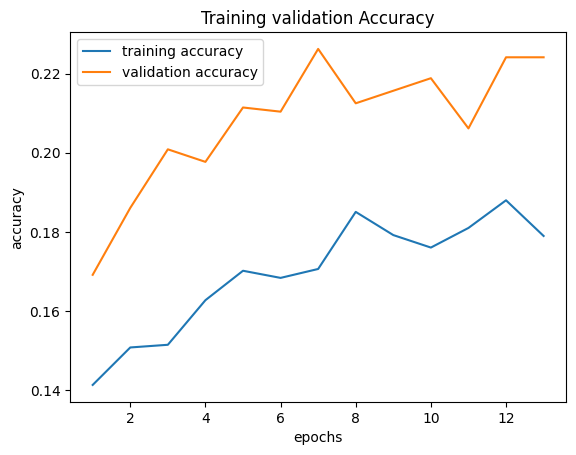

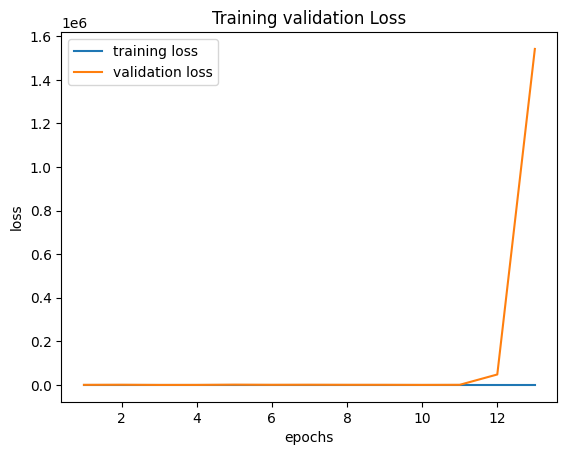

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training validation Accuracy')
plt.show()

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training validation Loss')
plt.show()

In [ ]:
# save model
model.save('21_may_2_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Load model

In [ ]:
model = load_model('21_may_2_model.h5')
model

# Load image

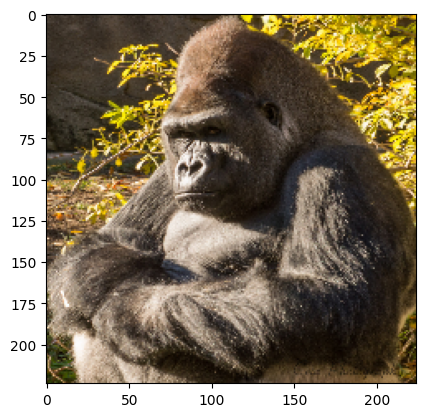

In [ ]:
img = cv2.imread(r"/content/split_data/test/gorilla/gorilla_10140.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
img = img/255.0
plt.imshow(img)
plt.show()

In [ ]:
img.shape

(224, 224, 3)

In [ ]:
input_img = img.reshape(1,224,224,3)
input_img.shape

(1, 224, 224, 3)

In [ ]:
output = model.predict(input_img)
output

1/1 [==============================] - 0s 28ms/step


array([[0.00155939, 0.05819847, 0.07475471, 0.00151354, 0.06302889,
        0.00380076, 0.02992894, 0.04939972, 0.15175325, 0.00895944,
        0.09093355, 0.09655774, 0.02423536, 0.10956248, 0.12547867,
        0.04981989, 0.04576571, 0.0147495 ]], dtype=float32)

In [ ]:
out = np.argmax(output)
out

8

# Model evaluation

In [ ]:
# #Final classification


# import time
# t0 = time.time()
# save_pred = {}
# Main_counter_1=0
# Main_counter_2=0
# count_1=0
# count_2=0
# count_3=0
# count_4=0
# count_5=0
# counter_hippo_leopard=0
# counter_cat=0
# counter_humpback=0
# counter_seal=0
# counter_chimp=0
# counter_pig=0
# counter_panda=0
# counter_rat_raccoon=0


# for img_path in glob.glob(r"D:\ZSL\CNN\Test_TRIAL_DATASET_1-CLASS_1\*\*"):




#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224,224))
#     img = img/255.0
#     #plt.imshow(img)
#     input_img = img.reshape(1,224,224,3)
#     output = model.predict(input_img)
#     out = np.argmax(output)
#     print('result is =',out)
#     if out == 0:

#             img: np.ndarray = np.asarray(tf.keras.preprocessing.image.load_img(
#             img_path))

#             # get prediction vector
#             prediction: np.ndarray = model_1_ZSL.predict(np.expand_dims(
#                 tf.keras.applications.vgg19.preprocess_input(tf.image.resize(
#                 img, (224, 224))), axis=0))

#             # get top-n labels by cosine similarity
#             most_similar: List[str] = fast_text_vectors.similar_by_vector(
#             prediction[0], topn=5)


#             for i in most_similar:
#                 if i[0] == 'bear':

#                     counter_panda+=1

#             for i in most_similar:
#                # if i[0] == img_path.split("\\")[-2]:
#                 if i[0] == 'chimp':
#                     counter_chimp+=1

#             for i in most_similar:
#                 if i[0] == img_path.split("\\")[-2]:
#                     counter_pig+=1



#             # display image
#             plt.figure(figsize=(2,2))
#             plt.imshow(img)
#             plt.axis('off')
#             plt.show()

#             # print the predictions for image
#             save_pred[img_path] = [x[0] for x in most_similar]
#             print("foler",img_path)
#             print(f"Prediction for image: {', '.join([x[0] for x in most_similar])}")
#             count_1+=1






#     else:


#             img: np.ndarray = np.asarray(tf.keras.preprocessing.image.load_img(
#             img_path))

#             # get prediction vector
#             prediction: np.ndarray = model_2_ZSL.predict(np.expand_dims(
#                 tf.keras.applications.vgg19.preprocess_input(tf.image.resize(
#                 img, (224, 224))), axis=0))

#             # get top-n labels by cosine similarity
#             most_similar: List[str] = fast_text_vectors.similar_by_vector(
#             prediction[0], topn=5)


#             for i in most_similar:
#                 if i[0] == img_path.split("\\")[-2]:

#                     counter_hippo_leopard+=1

#             for i in most_similar:
#                 if i[0] == 'sealskin':
#             #  if i[0] == 'dog':
#                     counter_seal+=1

#             for i in most_similar:
#                # if i[0] == img_path.split("\\")[-2]:
#                 if i[0] == 'humpback':
#                     counter_humpback+=1

#             for i in most_similar:
#                 if i[0] == img_path.split("\\")[-2]:
#                     counter_rat_raccoon+=1

#             for i in most_similar:
#                 if i[0] == 'cat':
#                     counter_cat+=1



#             # display image
#             plt.figure(figsize=(2,2))
#             plt.imshow(img)
#             plt.axis('off')
#             plt.show()

#             # print the predictions for image
#             save_pred[img_path] = [x[0] for x in most_similar]
#             print("foler",img_path)
#             print(f"Prediction for image: {', '.join([x[0] for x in most_similar])}")
#             count_2+=1

# print("Testing time:", time.time()-t0)


# Way 2


In [ ]:
from keras.utils import image_dataset_from_directory

In [ ]:
batch_size = 4
img_height = 224
img_width = 224
image_dataset_path = "/content/TRail_dataset_awa2_colab"

train_data=image_dataset_from_directory(image_dataset_path,
                                        labels="inferred",
                                        label_mode="int",
                                        validation_split=0.2,
                                        subset="training",
                                        seed=123,
                                        image_size=(img_height, img_width),
                                        batch_size=batch_size)

val_data = image_dataset_from_directory(image_dataset_path,
                                      labels="inferred",
                                      label_mode="int",
                                      validation_split=0.2,
                                      subset="validation",
                                      seed=123,
                                      image_size=(img_height, img_width),
                                      batch_size=batch_size)

Found 6342 files belonging to 18 classes.
Using 5074 files for training.
Found 6342 files belonging to 18 classes.
Using 1268 files for validation.


In [ ]:
lenth_train_data = len(train_data.file_paths)
lenth_val_data = len(val_data.file_paths)
lenth_train_data,  lenth_val_data

(5074, 1268)

In [ ]:
class_names = train_data.class_names
print(class_names)

['blue_whale', 'bobcat', 'cow', 'dolphin', 'gorilla', 'killer_whale', 'lion', 'mouse', 'ox', 'polar_bear', 'rabbit', 'rhinoceros', 'siamese+cat', 'skunk', 'spider_monkey', 'squirrel', 'tiger', 'walrus']


In [ ]:
x_l=[]
y_l = []
for x,y in train_data:
  x_l.append(x)
  y_l.append(y)
x_train=np.concatenate(x_l,axis=0)
y_train=np.concatenate(y_l,axis=0)


In [ ]:
x_train[0]

array([[[ 61.480705,  89.48071 , 101.90928 ],
        [ 59.928574,  87.92857 , 100.35714 ],
        [ 61.291935,  89.0464  , 101.54512 ],
        ...,
        [119.95989 , 140.05638 , 111.95489 ],
        [118.71429 , 136.71428 , 112.99552 ],
        [115.92857 , 135.71428 , 111.35714 ]],

       [[102.4509  , 134.80804 , 120.37946 ],
        [ 97.426346, 129.42635 , 117.050385],
        [ 95.97991 , 126.7583  , 117.13919 ],
        ...,
        [123.686714, 152.68672 , 107.81454 ],
        [120.742836, 148.76915 , 108.28571 ],
        [119.98243 , 148.00879 , 109.28571 ]],

       [[121.92682 , 152.8554  , 121.141106],
        [120.78348 , 151.71207 , 120.00829 ],
        [118.9536  , 149.76817 , 119.48485 ],
        ...,
        [118.88597 , 152.88597 , 102.88597 ],
        [118.211266, 152.0684  , 102.13984 ],
        [119.93033 , 151.93033 , 103.07319 ]],

       ...,

       [[110.19732 , 126.1263  ,  77.11884 ],
        [145.30833 , 155.72897 , 102.5378  ],
        [ 70.62718 ,  

In [ ]:
y_train[0]

2

In [ ]:
x_l=[]
y_l = []
for x,y in val_data:
  x_l.append(x)
  y_l.append(y)
x_val=np.concatenate(x_l,axis=0)
y_val =np.concatenate(y_l,axis=0)

In [ ]:
x_val[0]

array([[[ 42.        , 123.        , 179.        ],
        [ 41.        , 122.        , 178.        ],
        [ 40.        , 121.        , 177.        ],
        ...,
        [ 31.410715  , 108.41071   , 164.41072   ],
        [ 30.607126  , 108.41071   , 164.41072   ],
        [ 29.276743  , 108.27674   , 164.27675   ]],

       [[ 42.        , 123.        , 179.        ],
        [ 41.        , 122.        , 178.        ],
        [ 40.        , 121.        , 177.        ],
        ...,
        [ 34.464287  , 111.46429   , 167.46428   ],
        [ 33.660698  , 111.46429   , 167.46428   ],
        [ 32.330315  , 111.330315  , 167.3303    ]],

       [[ 42.        , 123.        , 179.        ],
        [ 41.        , 122.        , 178.        ],
        [ 40.        , 121.        , 177.        ],
        ...,
        [ 39.107143  , 116.10714   , 172.10715   ],
        [ 38.303555  , 116.10714   , 172.10715   ],
        [ 36.107143  , 115.10714   , 171.10715   ]],

       ...,

      

In [ ]:
y_val[0]

17

In [ ]:
y_train = np.reshape(y_train,(lenth_train_data,1))
y_val = np.reshape(y_val,(lenth_val_data,1))

In [ ]:
y_train_str = np.array(list(map(lambda x: np.array([class_names[x[0]]]), y_train)))
y_val_str = np.array(list(map(lambda x: np.array([class_names[x[0]]]), y_val)))

In [ ]:
y_train_str

array([['cow'],
       ['dolphin'],
       ['squirrel'],
       ...,
       ['bobcat'],
       ['polar_bear'],
       ['rabbit']], dtype='<U13')

In [ ]:
y_val_str

array([['walrus'],
       ['siamese+cat'],
       ['ox'],
       ...,
       ['gorilla'],
       ['dolphin'],
       ['spider_monkey']], dtype='<U13')

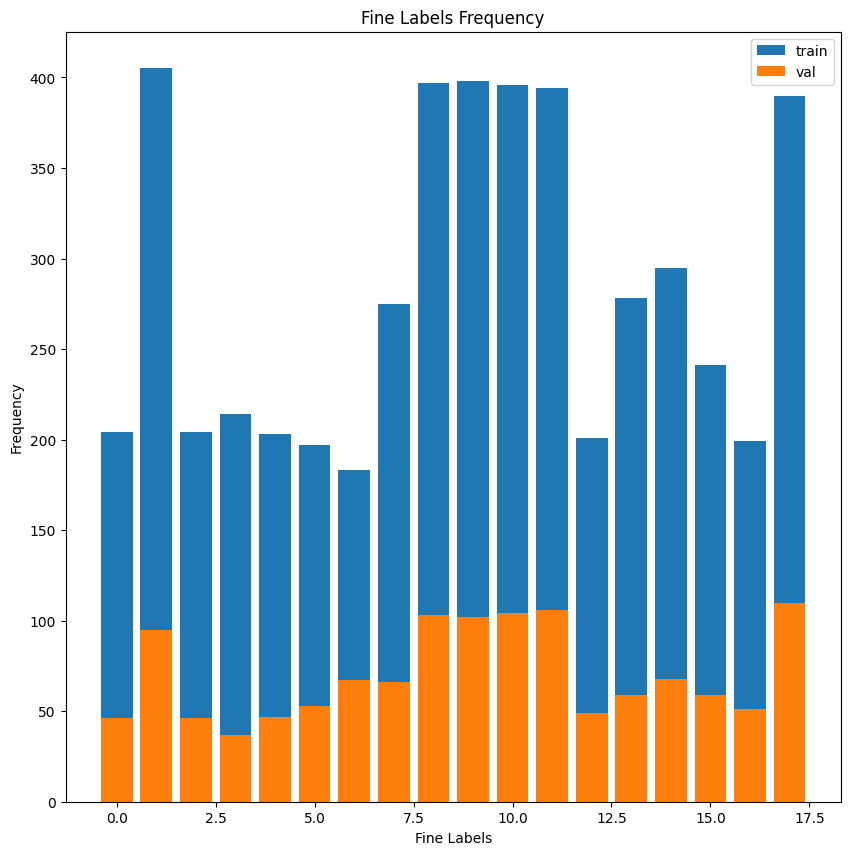

In [ ]:
unique = None
counts = 0

plt.figure(figsize=(10, 10))
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, label='train')
unique, counts = np.unique(y_val, return_counts=True)
plt.bar(unique, counts, label='val')

plt.title('Fine Labels Frequency')
plt.xlabel('Fine Labels')
plt.ylabel('Frequency')

plt.legend()
plt.show()

In [ ]:
# from gensim.models.keyedvectors import KeyedVectors
# import gensim.downloader as api
# from gensim.models import KeyedVectors


In [ ]:
# fast_text_vectors = gdownloader.load("fasttext-wiki-news-subwords-300")
# fast_text_vectors

# fast_text_vectors = KeyedVectors.load("fstwk.d2v")
# fast_text_vectors

In [ ]:
from gensim.test.utils import lee_corpus_list
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
model = Word2Vec(lee_corpus_list, vector_size=24, epochs=100)
word_vectors = model.wv

In [ ]:
word_vectors.save('vectors.kv')
reloaded_word_vectors = KeyedVectors.load('vectors.kv')

In [ ]:
reloaded_word_vectors

In [ ]:
for i in reloaded_word_vectors:
  print(i)
  break

[-0.29022932  0.3971533  -0.31516457  0.4931282  -0.35993645  0.03998454
 -0.75413907 -0.1466198   0.376487   -0.02195504  0.09333038 -0.27092376
 -0.3426134  -0.12125009 -0.25979963 -0.6898057  -0.08507395 -0.18381122
  0.2590788  -0.5034777   0.86455613  0.4640999   0.35493073 -0.05714633]


In [ ]:
# lee_corpus_list

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
fast_text_vectors.save('fstwk.d2v')
fast_text_vectors = KeyedVectors.load("fstwk.d2v")

NameError: ignored

# Classification Report

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Zero_Shot_Learning/Test_data/test_test.zip", 'r')
zip_ref.extractall()
zip_ref.close()

print('done...')

done...


In [11]:
import numpy as np
import pandas as pd

import glob
import time
import random
import cv2
import tensorflow as tf
import keras

from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.applications.vgg19 import preprocess_input
from tensorflow.image import resize
from keras.preprocessing.text import text_to_word_sequence

from gensim.models.keyedvectors import KeyedVectors
import gensim.downloader as api

In [12]:
def word_list_to_avg_vector(lst):
  """
  Transform a word list to its average vector
  Parameters:
      lst (List[str]): string to transform to vector
  Returns:
      np.ndarray: vector representation of word list
  """
  # create empty array
  vec: np.ndarray = np.array([0.0] * 300)

  word = ''
  for word in lst:
      # add word vector to sentence vectors or zero if no word vector
      vec += fast_text_vectors.word_vec(word)

  # return average vector (take sentence length into consideration)
  return vec / len(lst)

In [62]:
class_list = sorted(list(set([img_path.split('/')[-2] for img_path in glob.glob(r"/content/test/*/*")])))
print(class_list)
class_dct = {class_name: class_list.index(class_name) for class_name in class_list}
# class_dct.update({'other': 18})
print(class_dct)
synonyms_class_dct = {'chimpanzee': ['chimpanzee', 'chimp', 'monkey'],
                      'giant_panda': ['giant_panda', 'giant', 'panda', 'bear'],
                      'seal': ['seal', 'sealskin', 'walrus'],
                      'rat': ['rat', 'mouse']}
print(synonyms_class_dct)

['chimpanzee', 'giant_panda', 'hippopotamus', 'humpback_whale', 'leopard', 'persian_cat', 'pig', 'raccoon', 'rat', 'seal']
{'chimpanzee': 0, 'giant_panda': 1, 'hippopotamus': 2, 'humpback_whale': 3, 'leopard': 4, 'persian_cat': 5, 'pig': 6, 'raccoon': 7, 'rat': 8, 'seal': 9}
{'chimpanzee': ['chimpanzee', 'chimp', 'monkey'], 'giant_panda': ['giant_panda', 'giant', 'panda', 'bear'], 'seal': ['seal', 'sealskin', 'walrus'], 'rat': ['rat', 'mouse']}


In [63]:
primary_model = load_model('/content/drive/MyDrive/Colab Notebooks/Zero_Shot_Learning/Model/Trail_1_Main_20_may_model.h5')
ZSL_class1_model = load_model('/content/drive/MyDrive/Colab Notebooks/Zero_Shot_Learning/Model/21_may_main_class_1_ZSL_model.h5')
ZSL_class2_model = load_model('/content/drive/MyDrive/Colab Notebooks/Zero_Shot_Learning/Model/21_may_main_class_2_ZSL_model.h5')

fine_labels = class_list
fine_labels_words = list(map(text_to_word_sequence, fine_labels))
# for word_list in fine_labels_words:
#   print(word_list)

# fast_text_vectors = api.load("fasttext-wiki-news-subwords-300")
# fast_text_vectors.save('fstwk_1.d2v')
fast_text_vectors = KeyedVectors.load("fstwk_1.d2v")

for word_list in fine_labels_words:
  for word in word_list:
    try:
      fast_text_vectors.word_vec(word)
    except Exception as err:
      print(f"-- {word} isn't in corpus --")


<ipython-input-63-87073cd52638>:17: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  fast_text_vectors.word_vec(word)


In [64]:
img_path_list, class_name_list, similar_items_list = [], [], []

for img_path in glob.glob(r"/content/test/*/*"):
  class_name = img_path.split('/')[-2]
  # print(f"img_path : {img_path} \t class_name : {class_name}")
  img_path_list.append(img_path)
  class_name_list.append(class_name)

  # load image
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224,224))
  img = img/255.0

  input_img = img.reshape(1,224,224,3)
  output = primary_model.predict(input_img)
  out = np.argmax(output)
  # print(f"result is : {out}")

  # load image as ndarray
  img = np.asarray(load_img(img_path))

  if out == 0:
    # get prediction vector
    prediction = ZSL_class1_model.predict(
        np.expand_dims(
            preprocess_input(resize(img, (224, 224))),
            axis=0)
        )
    # print(f"prediction : {prediction}")

  else:
    # get prediction vector
    prediction = ZSL_class2_model.predict(
        np.expand_dims(
            preprocess_input(resize(img, (224, 224))),
            axis=0)
        )
    # print(f"prediction : {prediction}")

  # get top-n labels by cosine similarity
  most_similar = fast_text_vectors.similar_by_vector(
      prediction[0],
      topn=10)
  most_similar_list = [ms[0] for ms in most_similar]
  # print(f"most_similar_list : {most_similar_list}")

  similar_items_list.append(most_similar_list)
  # break
print("Done")

1/1 [==============================] - 0s 183ms/step
Done


In [17]:
# img_path_list, class_name_list, similar_items_list

In [65]:
df = pd.DataFrame(columns=['input_image', 'class_name', 'similar_list'])
df['input_image'] = img_path_list
df['class_name'] = class_name_list
df['similar_list'] = similar_items_list
df.head()

,input_image,class_name,similar_list
0,/content/test/persian_cat/persian+cat_10436.jpg,persian_cat,"[cat, cats, siamese, kitten, housecat, dog, -c..."
1,/content/test/persian_cat/persian+cat_10192.jpg,persian_cat,"[cat, cats, siamese, housecat, kitten, -cat, f..."
2,/content/test/persian_cat/persian+cat_10110.jpg,persian_cat,"[cat, cats, siamese, kitten, housecat, dog, fe..."
3,/content/test/persian_cat/persian+cat_10457.jpg,persian_cat,"[cat, cats, siamese, kitten, housecat, dog, fe..."
4,/content/test/persian_cat/persian+cat_10077.jpg,persian_cat,"[cat, cats, siamese, housecat, kitten, dog, fe..."


In [66]:
# for index, row in df.iterrows():
#   if row["class_name"] in list(synonyms_class_dct.keys()):
#     print(row["class_name"], list(synonyms_class_dct.keys()), row["class_name"] in list(synonyms_class_dct.keys()))
#     for element in synonyms_class_dct[row["class_name"]]:
#       if element in row["similar_list"]:
#         print(element, row["similar_list"])
#         break


In [67]:
predicted_right = []
actual_class, predicted_class = [], []
for index, row in df.iterrows():
  # print(row["class_name"], row["similar_list"], row["similar_list"], row["class_name"] in row["similar_list"])

  if row["class_name"] in list(synonyms_class_dct.keys()):
    # print(synonyms_class_dct[row["class_name"]], any(synonyms_class_dct[element] in row["similar_list"] for element in list(synonyms_class_dct.keys())))
    if any(element in row["similar_list"] for element in synonyms_class_dct[row["class_name"]]):
      predicted_right.append(True)
      actual_class.append(class_dct[row["class_name"]])
      predicted_class.append(class_dct[row["class_name"]])
    else:
      predicted_right.append(row["class_name"] in row["similar_list"])
      actual_class.append(class_dct[row["class_name"]])
      if row["similar_list"][0] in list(class_dct.keys()):
        predicted_class.append(class_dct[row["similar_list"][0]])
        # print(row["class_name"], row["similar_list"], row["class_name"] in row["similar_list"])
      else:
        tmp_class = list(class_dct.keys())
        tmp_class.remove(row["class_name"])
        predicted_class.append(class_dct[random.choice(tmp_class)])

  elif '_' in row["class_name"]:
    first_name, second_name = row["class_name"].split('_')
    # print(first_name, second_name)
    if first_name in row["similar_list"] or second_name in row["similar_list"]:
      predicted_right.append(True)
      actual_class.append(class_dct[row["class_name"]])
      predicted_class.append(class_dct[row["class_name"]])
      # print(row["class_name"], row["similar_list"], row["class_name"] in row["similar_list"])
    else:
      predicted_right.append(row["class_name"] in row["similar_list"])
      actual_class.append(class_dct[row["class_name"]])
      if row["similar_list"][0] in list(class_dct.keys()):
        predicted_class.append(class_dct[row["similar_list"][0]])
        # print(row["class_name"], row["similar_list"], row["class_name"] in row["similar_list"])
      else:
        tmp_class = list(class_dct.keys())
        tmp_class.remove(row["class_name"])
        predicted_class.append(class_dct[random.choice(tmp_class)])

  elif row["class_name"] in row["similar_list"]:
    predicted_right.append(row["class_name"] in row["similar_list"])
    actual_class.append(class_dct[row["class_name"]])
    predicted_class.append(class_dct[row["class_name"]])
    # print(row["class_name"], row["similar_list"], row["class_name"] in row["similar_list"])

  else:
    predicted_right.append(row["class_name"] in row["similar_list"])
    actual_class.append(class_dct[row["class_name"]])
    if row["similar_list"][0] in list(class_dct.keys()):
      predicted_class.append(class_dct[row["similar_list"][0]])
      # print(row["class_name"], row["similar_list"], row["class_name"] in row["similar_list"])
    else:
      tmp_class = list(class_dct.keys())
      tmp_class.remove(row["class_name"])
      predicted_class.append(class_dct[random.choice(tmp_class)])

  # print(index, len(predicted_right), len(actual_class), len(predicted_class))
  # if (index+1) != len(predicted_right):
  #   print(row["class_name"], row["similar_list"], row["class_name"] in row["similar_list"])
  #   break

In [68]:
df['predicted_right'] = predicted_right
df['actual_class'] = actual_class
df['predicted_class'] = predicted_class
df.head()

,input_image,class_name,similar_list,predicted_right,actual_class,predicted_class
0,/content/test/persian_cat/persian+cat_10436.jpg,persian_cat,"[cat, cats, siamese, kitten, housecat, dog, -c...",True,5,5
1,/content/test/persian_cat/persian+cat_10192.jpg,persian_cat,"[cat, cats, siamese, housecat, kitten, -cat, f...",True,5,5
2,/content/test/persian_cat/persian+cat_10110.jpg,persian_cat,"[cat, cats, siamese, kitten, housecat, dog, fe...",True,5,5
3,/content/test/persian_cat/persian+cat_10457.jpg,persian_cat,"[cat, cats, siamese, kitten, housecat, dog, fe...",True,5,5
4,/content/test/persian_cat/persian+cat_10077.jpg,persian_cat,"[cat, cats, siamese, housecat, kitten, dog, fe...",True,5,5


In [71]:
df.to_csv("result.csv", index = False)

[[ 86   6   4   1   2   0   3   1   4   3]
 [  6  54   6  13   7   7  14   6   8  11]
 [  6   9  15   7   8  15  17   8   8  11]
 [  0   0   0 105   0   0   0   1   0   1]
 [  9   3   9   6  64   4   1   6   4   3]
 [  0   1   1   1   1 103   3   0   1   2]
 [  8   8   8  15   7  14  20   8   8  12]
 [  1   5   4   3   2   1   5  47   5   5]
 [  2   2   0   0   1   1   0   3  38   0]
 [  8   4  10   6   3   5   5   5   7  96]] 

Accuracy: 0.594134 

Error rate: 0.405866 

              precision    recall  f1-score   support

           0       0.68      0.78      0.73       110
           1       0.59      0.41      0.48       132
           2       0.26      0.14      0.19       104
           3       0.67      0.98      0.80       107
           4       0.67      0.59      0.63       109
           5       0.69      0.91      0.78       113
           6       0.29      0.19      0.23       108
           7       0.55      0.60      0.58        78
           8       0.46      0.81   

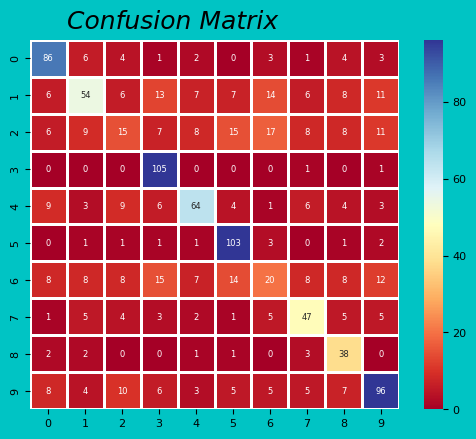

In [72]:
# confusion matrix
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
from sklearn.metrics import accuracy_score
# classification_report
from sklearn.metrics import classification_report
# kappa
from sklearn.metrics import cohen_kappa_score


true_labels = df['actual_class']
predicted_labels = df['predicted_class']

matrix = confusion_matrix(true_labels, predicted_labels)
print(matrix, '\n')

accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy: %f' % accuracy, '\n')
print('Error rate: %f' % (1-accuracy), '\n')

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report, '\n')

kappa = cohen_kappa_score(true_labels, predicted_labels)
print('Cohens kappa: %f' % kappa)



# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams['font.size'] = 8
bg_color = (0, 0.77, 0.77)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color

fig, ax = plt.subplots(1)

plt.text(1, -.3, "Confusion Matrix", fontsize = 18, color='Black', fontstyle='italic')

ax = sns.heatmap(matrix, annot=True, annot_kws={'size':6}, fmt="d",
                 robust=True, linewidths=.9, cmap="RdYlBu", square=True)
# vmin=0, vmax=350,
plt.savefig("Confusion_Matrix.jpeg", dpi=300, facecolor=bg_color, transparent=True)
plt.show()


In [60]:
print(class_dct)

{'chimpanzee': 0, 'giant_panda': 1, 'hippopotamus': 2, 'humpback_whale': 3, 'leopard': 4, 'persian_cat': 5, 'pig': 6, 'raccoon': 7, 'rat': 8, 'seal': 9}
